<a href="https://colab.research.google.com/github/beltranster/mbm/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

From: https://keras.io/guides/transfer_learning/

In [6]:
#layer = keras.layers.Dense(3)
layer = keras.layers.BatchNormalization()
layer.build((None, 4))
layer.trainable = False
print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights: ", len(layer.non_trainable_variables))

weights: 4
trainable_weights: 0
non_trainable_weights:  4


In [27]:
#make the model
layer1 = keras.layers.Dense(3, activation="relu")
layer2 = keras.layers.Dense(3, activation="sigmoid")
model = keras.Sequential([keras.Input(shape=(3,)), layer1, layer2])

In [28]:
#freeze teh first layer
layer1.trainable = False

In [29]:
#keep a copy of the weights of layer 1
initial_layer1_weights = layer1.get_weights()

In [30]:
#train
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step - loss: 0.0608


In [31]:
final_layer1_weights = layer1.get_weights()

In [33]:
np.testing.assert_allclose(
    initial_layer1_weights[0], final_layer1_weights[0]
)
np.testing.assert_allclose(
    initial_layer1_weights[1], final_layer1_weights[1]
)

# **An end-to-end example: fine-tuning an image classification model on a cats vs. dogs dataset**

In [3]:
tfds.disable_progress_bar()

In [4]:
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True, #include labels
)

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [5]:
print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {validation_ds.cardinality()}")
print(f"Number of test samples: {test_ds.cardinality()}")

Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


In [12]:
type(train_ds.take(9))

tensorflow.python.data.ops.take_op._TakeDataset

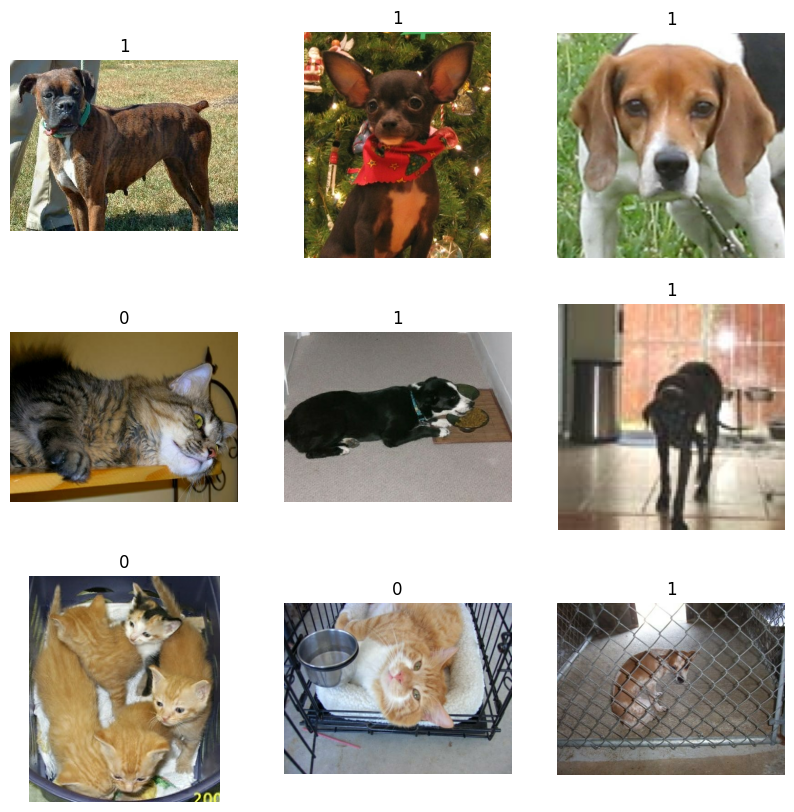

In [14]:
#Images are different sizes
plt.figure(figsize = (10,10))
for i, (image,label) in enumerate(train_ds.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image)
  plt.title(int(label))
  plt.axis("off")


Standardize to a fixed image size. We pick 150x150.
Normalize pixel values between -1 and 1. We'll do this using a Normalization layer as part of the model itself.

In [15]:
resize_fn = keras.layers.Resizing(150,150)
train_ds = train_ds.map(lambda x,y:(resize_fn(x), y))
validation_ds = validation_ds.map(lambda x,y:(resize_fn(x), y))
test_ds = test_ds.map(lambda x,y:(resize_fn(x), y))

## Random data augmentation

> artificial yet realistic transformations of the images



In [18]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(x):
  for layer in augmentation_layers:
    x = layer(x)
  return x

train_ds = train_ds.map(lambda x,y:(data_augmentation(x), y))

In [19]:
#Let's batch the data and use prefetching to optimize loading speed.
from tensorflow import data as tf_data

batch_size = 64

train_ds = train_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
validation_ds = validation_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

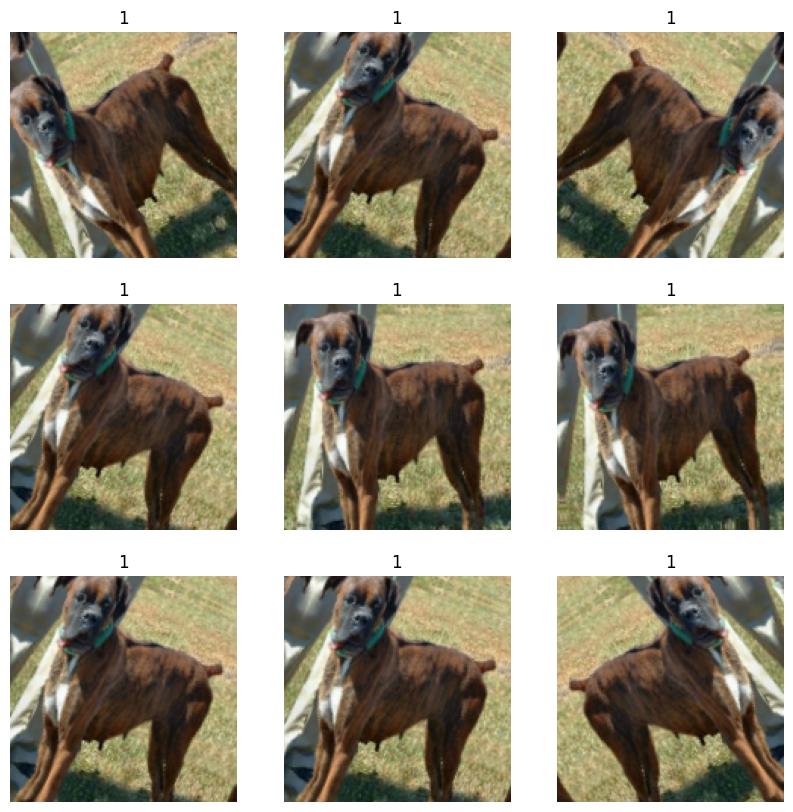

In [20]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

# Build a model

In [23]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling (Rescaling)       │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 1)             │      2,049 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [24]:
#train the top layer
model.compile(optimizer = keras.optimizers.Adam(),
              loss = keras.losses.BinaryCrossentropy(from_logits=True),
              metrics = [keras.metrics.BinaryAccuracy()])

In [25]:
epochs = 2
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/2
146/146 ━━━━━━━━━━━━━━━━━━━━ 1195s 8s/step - binary_accuracy: 0.8653 - loss: 0.2676 - val_binary_accuracy: 0.9682 - val_loss: 0.0861
Epoch 2/2
146/146 ━━━━━━━━━━━━━━━━━━━━ 1083s 7s/step - binary_accuracy: 0.9480 - loss: 0.1259 - val_binary_accuracy: 0.9708 - val_loss: 0.0791


In [ ]:
#fine tuning
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(optimizer = keras.optimizers.Adam(1e-5),
              loss = keras.losses.BinaryCrossentropy(from_logits=True),
              metrics = [keras.metrics.BinaryAccuracy()])

epochs =1
print("Fine tuning: fitting end-to-end model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling (Rescaling)       │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)    │ 20,861,480 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 1)             │      2,049 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,867,629 (79.60 MB)

 Trainable params: 20,809,001 (79.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 4,100 (16.02 KB)

Fine tuning: fitting end-to-end model
131/146 ━━━━━━━━━━━━━━━━━━━━ 6:29 26s/step - binary_accuracy: 0.8540 - loss: 0.3652

In [ ]:
#evaluation
model.evaluate(test_ds)